# NOT FINISHED YET

In [1]:
from __future__ import division

import os
import time
import sys
import random

import numpy
import matplotlib.pyplot as plt
import gc
from skimage.transform import resize
from IPython.display import clear_output
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim

%load_ext tensorboard

In [4]:
class ImageBuffer:
    """Fixed-size buffer to store image tuples."""

    def __init__(self, buffer_size):
        """Initialize a ImageBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.images = namedtuple("Images", field_names=['real_image_X', 'fake_image_X', 
                                                        'real_image_Y', 'fake_image_Y'])
    
    def add(self, real_image_X, fake_image_X, real_image_Y, fake_image_Y):
        """Add a new images to memory."""
        image_pair = self.images(real_image_X, fake_image_X, real_image_Y, fake_image_Y)
        self.memory.append(image_pair)
    
    def sample(self):
        """Return a batch of image tuples from memory."""
        return self.memory.popleft()

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def model_summary(model):
    print('=================================================================')
    print(model)
    print('=================================================================')
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Total params: {:,}'.format(total_params))
    print('Trainable params: {:,}'.format(trainable_params))
    print('Non-trainable params: {:,}'.format(total_params - trainable_params))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size=7, strides=1, padding=0, activation=nn.ReLU):
        super(ConvBlock, self).__init__()
        self.blocks = nn.Sequential(
                                        nn.Conv2d(in_channels, out_channels=filters, kernel_size=kernel_size, stride=strides, padding=padding),
                                        nn.InstanceNorm2d(num_features=filters),
                                        activation(inplace=True))
    
    def forward(self, input_tensor):
        x = self.blocks(input_tensor)
        return x

class DeConvBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size=7, strides=1, padding=0, activation=nn.ReLU):
        super(DeConvBlock, self).__init__()
        self.blocks = nn.Sequential(
                                    nn.ConvTranspose2d(in_channels, out_channels=filters, kernel_size=kernel_size, stride=strides, padding=padding),
                                    nn.InstanceNorm2d(num_features=filters),
                                    activation(inplace=True))
    
    def forward(self, input_tensor):
        x = self.blocks(input_tensor)
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size=3, strides=1, padding=0, activation=nn.ReLU):
        super(ResidualBlock, self).__init__()
        self.conv_blocks = nn.Sequential(
                                            nn.Conv2d(in_channels, out_channels=filters, kernel_size=kernel_size, stride=strides, padding=padding),
                                            nn.ReflectionPad2d(1),
                                            nn.InstanceNorm2d(num_features=filters),
                                            activation(inplace=True),
                                            nn.Conv2d(in_channels, out_channels=filters, kernel_size=kernel_size, stride=strides, padding=padding),
                                            nn.ReflectionPad2d(1),
                                            nn.InstanceNorm2d(num_features=filters))
    
    def forward(self, input_tensor):
        x = self.conv_blocks(input_tensor)
        x = x + input_tensor
        return x
    
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = None
    def forward(self, x):
        pass
    def summary(self):
        if self.model != None:
            print('=================================================================')
            print(self.model)
            print('=================================================================')
            total_params = sum(p.numel() for p in self.model.parameters())
            trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            print('Total params: {:,}'.format(total_params))
            print('Trainable params: {:,}'.format(trainable_params))
            print('Non-trainable params: {:,}'.format(total_params - trainable_params))
        else:
            print('Model not created')
    
class ResNetGenerator(BaseModel):
    def __init__(self, input_channel=3, output_channel=3, filters=64, n_blocks=9):
        super(ResNetGenerator, self).__init__()
        # Downsample layers
        layers = [
                      nn.ReflectionPad2d(3),
                      ConvBlock(in_channels=input_channel, filters=filters, kernel_size=7, strides=1, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters, filters=filters * 2, kernel_size=3, strides=2, padding=1, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters * 2, filters=filters * 4, kernel_size=3, strides=2, padding=1, activation=nn.LeakyReLU)
        ]
        
        # Residual layers
        for i in range(n_blocks):
            layers.append(ResidualBlock(in_channels=filters * 4, filters=filters * 4, kernel_size=3, strides=1, activation=nn.LeakyReLU))
        
        # Upsample layers
        layers += [
                        DeConvBlock(in_channels=filters * 4, filters=filters * 2, kernel_size=3, strides=2, padding=1, activation=nn.LeakyReLU),
                        DeConvBlock(in_channels=filters * 2, filters=filters, kernel_size=3, strides=2, padding=1, activation=nn.LeakyReLU),
                        nn.ReflectionPad2d(3),
                        nn.Conv2d(in_channels=filters, out_channels=output_channel, kernel_size=7, stride=1, padding=0)
        ]
        # Output layer
        layers += [nn.Tanh()]
        
        # Create model
        self.model = nn.Sequential(*layers)
    
    def forward(self, input_tensor):
        x = self.model(input_tensor)
        return x
    
class PatchGANDiscriminator(BaseModel):
    def __init__(self, input_channel, filters=64):
        super(PatchGANDiscriminator, self).__init__()

        layers = [
                      nn.Conv2d(in_channels=input_channel, out_channels=filters, kernel_size=4, stride=2, padding=0),
                      nn.LeakyReLU(inplace=True),
                      ConvBlock(in_channels=filters, filters=filters * 2, kernel_size=4, strides=2, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters * 2, filters=filters * 4, kernel_size=4, strides=2, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters * 4, filters=filters * 8, kernel_size=4, strides=1, padding=1, activation=nn.LeakyReLU),
        ]
        # Output layer
        layers += [nn.Conv2d(in_channels=filters * 8, out_channels=1, kernel_size=4, stride=1, padding=1)]
        # Create model
        self.model = nn.Sequential(*layers)
    
    def forward(self, input_tensor):
        x = self.model(input_tensor)
        return x

NameError: name 'nn' is not defined

In [6]:
INPUT_SHAPE = (256, 256, 3)
SCALE_WIDTH = 256
DATASET_PATH = 'datasets/monet2photo' # Dataset path
logdir = os.path.join("logs", 'train_data') # Sets up a log directory.

USE_BUFFER = True # Use image buffer to train discriminator
REPLAY_PROB = 0.5
BUFFER_SIZE = 50
BATCH_SIZE = 1

EPOCHs = 200
CURRENT_EPOCH = 1
SAVE_EVERY_N_EPOCH = 5

DISCRIMINATOR_LOSS_WEIGHT = 0.5
SOFT_FAKE_LABEL_RANGE = [0.0, 0.3]
SOFT_REAL_LABEL_RANGE = [0.7, 1.2]
LR = 0.0002
LR_DECAY_EPOCH = 100
# loss weight for cycle consistency
LAMBDA = 10

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

In [7]:
G_XtoY = ResNetGenerator(input_channel=3, output_channel=3, filters=64, n_blocks=5)
G_YtoX = ResNetGenerator(input_channel=3, output_channel=3, filters=64, n_blocks=5)
# G_XtoY = build_unet_generator()
# G_YtoX = build_unet_generator()

In [8]:
G_XtoY.summary()

Model: "G_XtoY"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
reflection_padding2d (Reflec (None, 262, 262, 3)       0         
_________________________________________________________________
conv_block (ConvBlock)       (None, 256, 256, 64)      9472      
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 128, 128, 128)     73856     
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 64, 64, 256)       295168    
_________________________________________________________________
residual_block (ResidualBloc (None, 64, 64, 256)       1180160   
_________________________________________________________________
residual_block_1 (ResidualBl (None, 64, 64, 256)       11801

In [9]:
Dx = PatchGANDiscriminator(input_channel=3, filters=64)
Dy = PatchGANDiscriminator(input_channel=3, filters=64)

In [10]:
Dx.summary()

Model: "Dx"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 127, 127, 64)      3136      
_________________________________________________________________
activation_20 (Activation)   (None, 127, 127, 64)      0         
_________________________________________________________________
conv_block_6 (ConvBlock)     (None, 62, 62, 128)       131200    
_________________________________________________________________
conv_block_7 (ConvBlock)     (None, 30, 30, 256)       524544    
_________________________________________________________________
conv_block_8 (ConvBlock)     (None, 30, 30, 512)       2097664   
_________________________________________________________________
Dx_output (Conv2D)           (None, 30, 30, 1)         8193     

In [12]:
# https://www.tensorflow.org/tutorials/generative/cyclegan

def random_crop(image):
    cropped_image = tf.image.random_crop(
                image, size=[BATCH_SIZE, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]])
    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
#     image = tf.image.resize(image, [int(aspect_ratio * SCALE_WIDTH), SCALE_WIDTH],
#                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(images, label):
    images = random_jitter(images)
    images = normalize(images)
    return images

def preprocess_image_test(images, label):
    images = normalize(images)
    return images

In [13]:
train_datagen_X = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                classes=['trainA'],
                                                )
train_datagen_Y = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                classes=['trainB'])
test_datagen_X = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                classes=['testA'])
test_datagen_Y = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                classes=['testB'])

train_image_generator_X = tf.data.Dataset.from_generator(lambda: train_datagen_X, output_types=(tf.int32, tf.int32))
train_image_generator_Y = tf.data.Dataset.from_generator(lambda: train_datagen_Y, output_types=(tf.int32, tf.int32))
test_image_generator_X = tf.data.Dataset.from_generator(lambda: test_datagen_X, output_types=(tf.int32, tf.int32))
test_image_generator_Y = tf.data.Dataset.from_generator(lambda: test_datagen_Y, output_types=(tf.int32, tf.int32))

train_image_generator_X = train_image_generator_X.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE)

train_image_generator_Y = train_image_generator_Y.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE)

test_image_generator_X = test_image_generator_X.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE)

test_image_generator_Y = test_image_generator_Y.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE)

Found 1072 images belonging to 1 classes.
Found 6287 images belonging to 1 classes.
Found 121 images belonging to 1 classes.
Found 751 images belonging to 1 classes.


In [14]:
train_image_generator_X = iter(train_image_generator_X)
train_image_generator_Y = iter(train_image_generator_Y)
test_image_generator_X = iter(test_image_generator_X)
test_image_generator_Y = iter(test_image_generator_Y)

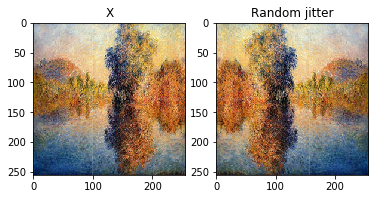

In [15]:
sample_X = next(train_image_generator_X)
sample_Y = next(train_image_generator_Y)
plt.subplot(121)
plt.title('X')
plt.imshow(sample_X[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random jitter')
plt.imshow(random_jitter(sample_X)[0] * 0.5 + 0.5)

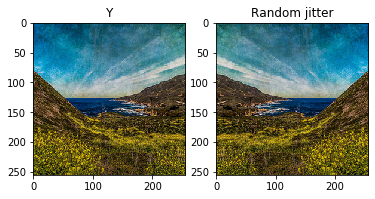

In [16]:
plt.subplot(121)
plt.title('Y')
plt.imshow(sample_Y[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random jitter')
plt.imshow(random_jitter(sample_Y)[0] * 0.5 + 0.5)

In [17]:
image_buffer = ImageBuffer(buffer_size=BUFFER_SIZE)

In [18]:
training_steps = min(len(train_datagen_X), len(train_datagen_Y))

In [19]:
print(training_steps)

1072


In [20]:
Dx_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
Dy_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
G_XtoY_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
G_YtoX_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

def calculate_learning_rate(epoch, current_lr):
    decay = 1.0 - max(0, epoch + 1 - LR_DECAY_EPOCH) / float(LR_DECAY_EPOCH + 1)
    return current_lr * decay

def set_learning_rate(new_lr):
    K.set_value(Dx_optimizer.lr, new_lr)
    K.set_value(Dy_optimizer.lr, new_lr)
    K.set_value(G_XtoY_optimizer.lr, new_lr)
    K.set_value(G_YtoX_optimizer.lr, new_lr)

In [21]:
def discriminator_loss(real_image, generated_image):
    
    real_loss = tf.reduce_mean(tf.square(real_image - tf.random.uniform(tf.shape(real_image),
                                                                        minval=SOFT_REAL_LABEL_RANGE[0],
                                                                        maxval=SOFT_REAL_LABEL_RANGE[1])))
    fake_loss = tf.reduce_mean(tf.square(generated_image - tf.random.uniform(tf.shape(generated_image),
                                                                        minval=SOFT_FAKE_LABEL_RANGE[0],
                                                                        maxval=SOFT_FAKE_LABEL_RANGE[1])))
    total_loss = real_loss + fake_loss
    return total_loss * 0.5

def generator_loss(generated_image):
    loss =tf.reduce_mean(tf.square(generated_image - tf.random.uniform(tf.shape(generated_image),
                                                                        minval=SOFT_REAL_LABEL_RANGE[0],
                                                                        maxval=SOFT_REAL_LABEL_RANGE[1])))
    return loss

def cycle_consistency_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return loss * LAMBDA

def identity_loss(real_image, generated_image):
    loss =tf.reduce_mean(tf.abs(real_image - generated_image))
    return loss * 0.5 * LAMBDA

In [22]:
checkpoint_path = r"./checkpoints/train"

ckpt = tf.train.Checkpoint(G_XtoY=G_XtoY,
                           G_YtoX=G_YtoX,
                           Dx=Dx,
                           Dy=Dy,
                           G_XtoY_optimizer=G_XtoY_optimizer,
                           G_YtoX_optimizer=G_YtoX_optimizer,
                           Dx_optimizer=Dx_optimizer,
                           Dy_optimizer=Dy_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [23]:
def generate_images(model, test_input, img_name='img', step=0):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    # Using the file writer, log the reshaped image.
    with file_writer.as_default():
        tf.summary.image(img_name, prediction * 0.5 + 0.5, step=step)
        file_writer.flush()
        print("done")
        
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [24]:

def train_step(real_image_X, real_image_Y, epoch=1, write_scalar=False):
    pass

    
def train_with_log(real_image_X, real_image_Y, epoch=1, write_scalar=False, trace=False):
    if trace:
        tf.summary.trace_on(graph=True, profiler=False)
        train_step(real_image_X, real_image_Y, epoch=epoch, write_scalar=write_scalar)
        print("Writing graph")
        with file_writer.as_default():
                      tf.summary.trace_export(
                          name="train_step",
                          step=epoch,
                          profiler_outdir=logdir)
        print("done")
        trace = False
    else:
        train_step(real_image_X, real_image_Y, epoch=epoch, write_scalar=write_scalar)
    return trace

done


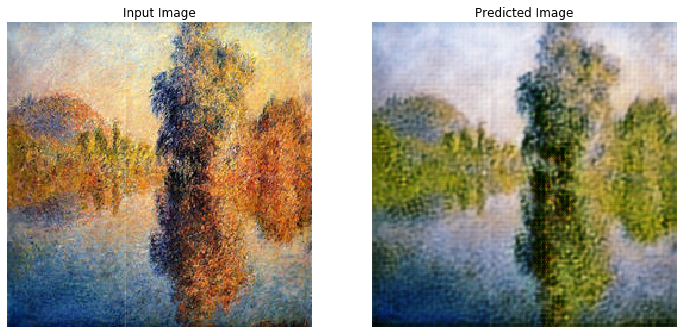

done


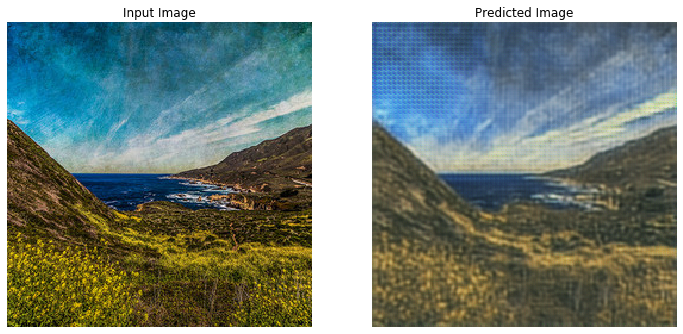

Time taken for epoch 6 is 414.8900237083435 sec

Start of epoch 7
..............................

In [ ]:
current_learning_rate = LR


trace = True
for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    current_learning_rate = calculate_learning_rate(epoch, current_learning_rate)
    set_learning_rate(current_learning_rate)
    
    for step in range(training_steps):
        real_image_X = train_image_generator_X.next()
        real_image_Y = train_image_generator_Y.next()   
        
        fake_image_X = G_YtoX.predict(real_image_Y)
        fake_image_Y = G_XtoY.predict(real_image_X)
        
        image_buffer.add(real_image_X, fake_image_X, real_image_Y, fake_image_Y)
        
        write_summary = True if (step >= training_steps - 1) else False
        
        if USE_BUFFER:
            if len(image_buffer) >= BUFFER_SIZE:
                trace = train_with_log(real_image_X, real_image_Y, epoch, write_summary, trace)
        else:
            trace = train_with_log(real_image_X, real_image_Y, epoch, write_summary, trace)
    
        if step % 10 == 0:
            print ('.', end='')
    
    clear_output(wait=True)
    # Using a consistent image (sample_X) so that the progress of the model
    # is clearly visible.
    generate_images(G_XtoY, sample_X, img_name='sample_X', step=epoch)
    generate_images(G_YtoX, sample_Y, img_name='sample_Y', step=epoch)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    gc.collect()